# Transfer Auto-encoder for MNIST<->SVHN transfer

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from torchvision import datasets
from torchvision import transforms

In [2]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the datasets

In [3]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
svhn = datasets.SVHN(root="/datasets/svhn", download=False, transform=transform)

In [5]:
X_svhn = svhn.data
X_svhn = X_svhn.reshape(len(X_svhn), 32*32*3) / 256
Y_svhn = svhn.labels.flatten()%10
X_svhn.shape

(73257, 3072)

In [6]:
X_svhn

array([[ 0.12890625,  0.05859375,  0.05859375, ...,  0.33984375,
         0.3359375 ,  0.30859375],
       [ 0.328125  ,  0.3359375 ,  0.30078125, ...,  0.34375   ,
         0.34375   ,  0.3125    ],
       [ 0.07421875,  0.078125  ,  0.09765625, ...,  0.91796875,
         0.90625   ,  0.90234375],
       ..., 
       [ 0.359375  ,  0.3671875 ,  0.4453125 , ...,  0.8359375 ,
         0.85546875,  0.8515625 ],
       [ 0.7421875 ,  0.80078125,  0.859375  , ...,  0.87109375,
         0.84375   ,  0.81640625],
       [ 0.84375   ,  0.86328125,  0.8828125 , ...,  0.70703125,
         0.66015625,  0.66796875]])

In [7]:
mnist = input_data.read_data_sets('/datasets/mnist', one_hot=False)

Extracting /datasets/mnist/train-images-idx3-ubyte.gz
Extracting /datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /datasets/mnist/t10k-labels-idx1-ubyte.gz


In [8]:
X_mnist = mnist.train.images
X_mnist = X_mnist.reshape(len(X_mnist), 28*28)
Y_mnist = mnist.train.labels
X_mnist.shape

(55000, 784)

## Create the model

### Placeholders

In [9]:
# source = tf.placeholder(tf.float32, shape=[None, 32*32*3], name='source')
source = tf.placeholder(tf.float32, shape=[None, 32*32*3], name='source')
target = tf.placeholder(tf.float32, shape=[None, 28*28], name='target')

### Convolutional transcoder
I'm using here a big part of the architecture described in [this code](https://github.com/hwalsuklee/tensorflow-mnist-VAE/blob/master/vae.py)

In [10]:
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

initializer = tf.contrib.layers.xavier_initializer()

def encoder(x):
    with tf.variable_scope("encoder", reuse=None):
        W0 = tf.get_variable('W0', shape=[32*32*3, 500], initializer=initializer)
        b0 = tf.get_variable('b0', shape=[500], initializer=initializer)
        h0 = tf.matmul(x, W0) + b0
        h0 = tf.nn.relu(h0)
        #h0 = tf.nn.dropout(h0, keep_prob)

        W1 = tf.get_variable('W1', shape=[500, 100], initializer=initializer)
        b1 = tf.get_variable('b1', shape=[100], initializer=initializer)
        z = tf.matmul(h0, W1) + b1
        z = tf.nn.relu(z)
        #z = tf.nn.dropout(z, keep_prob)
    return z

def decoder(z):
    with tf.variable_scope("decoder", reuse=None):
        W0 = tf.get_variable('W0', shape=[100, 500], initializer=initializer)
        b0 = tf.get_variable('b0', shape=[500], initializer=initializer)
        h0 = tf.matmul(z, W0) + b0
        h0 = tf.nn.relu(h0)
        h0 = tf.nn.dropout(h0, keep_prob)

        W1 = tf.get_variable('W1', shape=[500, 28*28], initializer=initializer)
        b1 = tf.get_variable('b1', shape=[28*28], initializer=initializer)
        y = tf.matmul(h0, W1) + b1
        y = tf.nn.sigmoid(y)
        #y = tf.nn.dropout(y, keep_prob)
    return y

### Losses and solver

In [11]:
X_output = decoder(encoder(source))

In [12]:
loss = tf.losses.mean_squared_error(target, X_output)

In [13]:
solver = tf.train.AdamOptimizer().minimize(loss)

## Execute the model

In [56]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))

In [57]:
sess.run(tf.global_variables_initializer())
loss_list = []

In [62]:
nb_iter = 1000
nb_samples = 10

for i in range(nb_iter):
    y = np.random.randint(0,10)
#     X_svhn_y = X_svhn[Y_svhn==y]
#     X_mnist_y = X_mnist[Y_mnist==y]
    sample_source = X_svhn[np.random.choice(len(X_svhn), nb_samples)]
    sample_target = X_mnist[np.random.choice(len(X_mnist), nb_samples)]
    _, loss_curr = sess.run([solver, loss],feed_dict={source: sample_source, target: sample_target, keep_prob : 0.9})
    
    loss_list.append(loss_curr)
    if i % (nb_iter//10) == 0:
        print('Iter: {}'.format(i))
        print('loss: {:.4}'. format(loss_curr))
        print()

Iter: 0
loss: 0.06799

Iter: 100
loss: 0.06905

Iter: 200
loss: 0.07019

Iter: 300
loss: 0.08221

Iter: 400
loss: 0.07196

Iter: 500
loss: 0.06618

Iter: 600
loss: 0.06487

Iter: 700
loss: 0.05736

Iter: 800
loss: 0.05911

Iter: 900
loss: 0.07015



## Display the results

In [63]:
X_source_trans = sess.run(X_output, feed_dict={source: X_svhn[:100], keep_prob:1})

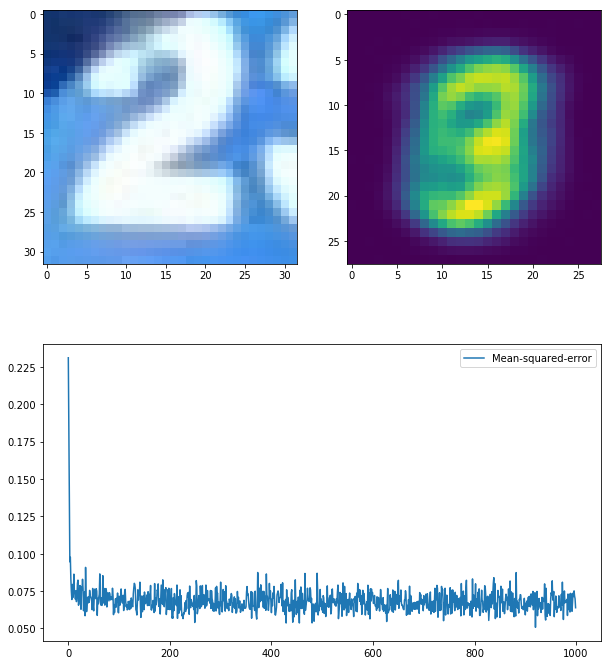

In [67]:
plt.rcParams['figure.figsize'] = (10, 12)
# plt.axes().set_aspect('equal', 'datalim')
#plt.axis([-3,3,-3,3])

index = 2
plt.subplot(2,2,1)
plt.imshow(np.transpose(X_svhn[index].reshape(3,32,32), (1,2,0)))
#plt.imshow(X_mnist[index].reshape(28,28))
plt.subplot(2,2,2)
plt.imshow(X_source_trans[index].reshape(28,28))

plt.subplot(2,1,2)
i_start = 0
plt.plot([loss_list[i_start+i] for i in range(len(loss_list[i_start:])) if i%2==0], label="Mean-squared-error")
plt.legend()

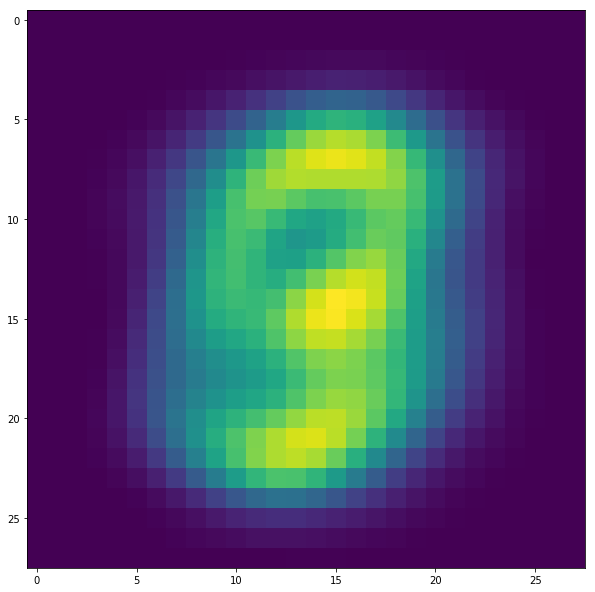

In [55]:
plt.imshow(np.average(X_mnist.reshape(len(X_mnist), 28, 28), axis=0))

In [75]:
X_mnist[Y_mnist==0].shape

(5444, 784)

In [96]:
Y_svhn%10

array([1, 9, 2, ..., 1, 6, 9], dtype=uint8)

In [73]:
Y_mnist

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [49]:
X_mnist.r

(55000, 784)

In [61]:
del(X_svhn_y)